In [36]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb  


# Step 2: Load Dataset
df = pd.read_csv('train.csv')

In [37]:
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


(None,
   Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
 0           FDA15         9.30          Low Fat         0.016047   
 1           DRC01         5.92          Regular         0.019278   
 2           FDN15        17.50          Low Fat         0.016760   
 3           FDX07        19.20          Regular         0.000000   
 4           NCD19         8.93          Low Fat         0.000000   
 
                Item_Type  Item_MRP Outlet_Identifier  \
 0                  Dairy  249.8092            OUT049   
 1            Soft Drinks   48.2692            OUT018   
 2                   Meat  141.6180            OUT049   
 3  Fruits and Vegetables  182.0950            OUT010   
 4              Household   53.8614            OUT013   
 
    Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
 0                       1999      Medium               Tier 1   
 1                       2009      Medium               Tier 3   
 2                       1999      

In [38]:
# 3. Detect & Handle Missing Values
df['Item_Weight'] = df.groupby('Item_Identifier')['Item_Weight'].transform(lambda x: x.fillna(x.mean()))
df['Item_Weight'].fillna(df['Item_Weight'].mean(), inplace=True)

df['Outlet_Size'].fillna(df.groupby('Outlet_Type')['Outlet_Size'].transform(lambda x: x.mode()[0]), inplace=True)

# 4. Handle Duplicates (if any)
df.drop_duplicates(inplace=True)

In [39]:
# 5. Standardize Categorical Values
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({
    'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'
})

In [40]:
# 6. Feature Engineering
df['Outlet_Years'] = 2013 - df['Outlet_Establishment_Year']
df['Item_Category'] = df['Item_Identifier'].apply(lambda x: x[:2])
df['Item_Category'] = df['Item_Category'].map({'FD': 'Food', 'NC': 'Non-Consumable', 'DR': 'Drinks'})

In [41]:
# Convert Non-Consumable items to Non-Edible
df.loc[df['Item_Category'] == 'Non-Consumable', 'Item_Fat_Content'] = 'Non-Edible'

# 7. Label Encoding
le = LabelEncoder()
cols_to_encode = ['Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Category']
for col in cols_to_encode:
    df[col] = le.fit_transform(df[col])

# 8. One-Hot Encoding for some categorical variables
df = pd.get_dummies(df, columns=['Item_Type', 'Outlet_Identifier'], drop_first=True)

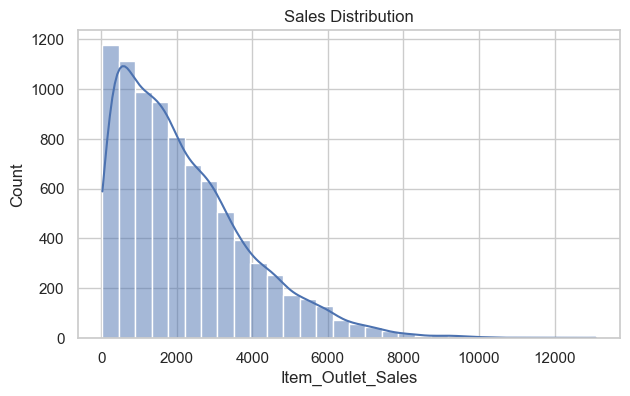

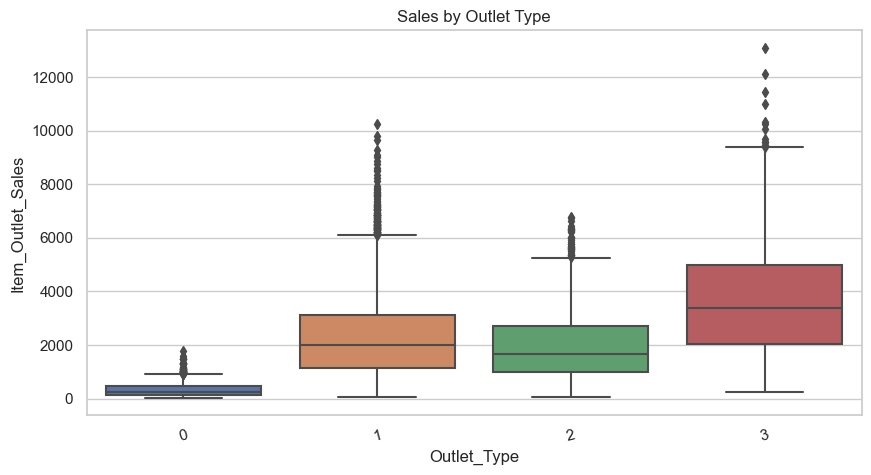

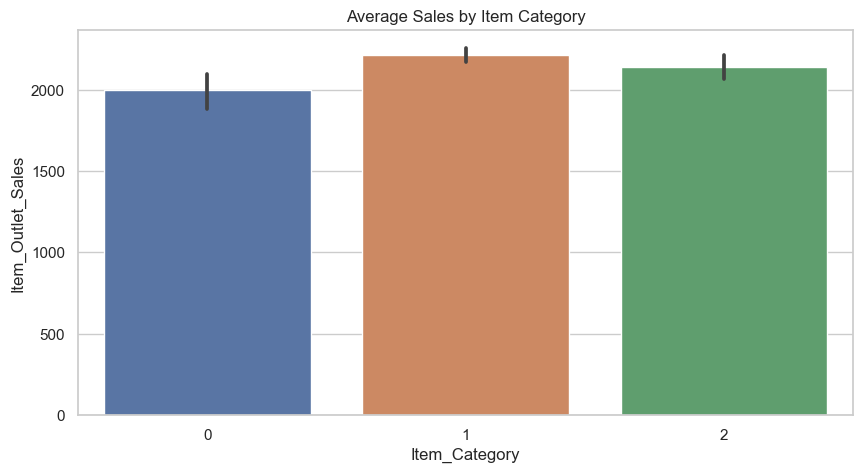

In [42]:
# 10. EDA (2–3 Plots)
plt.figure(figsize=(7, 4))
sns.histplot(df['Item_Outlet_Sales'], bins=30, kde=True)
plt.title("Sales Distribution")
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='Outlet_Type', y='Item_Outlet_Sales')
plt.xticks(rotation=15)
plt.title("Sales by Outlet Type")
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='Item_Category', y='Item_Outlet_Sales', estimator=np.mean)
plt.title("Average Sales by Item Category")
plt.show()

In [43]:
# Drop unused columns
df.drop(['Item_Identifier', 'Outlet_Establishment_Year'], axis=1, inplace=True)

# 11. Prepare Data for Modeling
X = df.drop("Item_Outlet_Sales", axis=1)
y = df["Item_Outlet_Sales"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
# 12. Train Models
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

In [46]:
# 13. Evaluation Function
def evaluate_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name}:\n  RMSE: {rmse:.2f}\n  R2 Score: {r2:.2f}\n")

# 14. Evaluate All Models
evaluate_model("Linear Regression", y_test, lr_preds)
evaluate_model("Random Forest", y_test, rf_preds)
evaluate_model("XGBoost", y_test, xgb_preds)

Linear Regression:
  RMSE: 1069.35
  R2 Score: 0.58

Random Forest:
  RMSE: 1078.03
  R2 Score: 0.57

XGBoost:
  RMSE: 1053.88
  R2 Score: 0.59

